# Exploratory Data Analysis

# Importing Modules

In [214]:
# Data import
import os
import sqlite3 as sq3

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots
import plotly.graph_objects

# Data Manipulation
from scipy import stats

# Data Processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA

# Miscellaneous
import json  # For working with JSON files

# Setting up Notebook

In [215]:
# Set up matplotlib to show figures in high resolution
%config InlineBackend.figure_formats = ['retina']

# Set up seaborn to show appropriate size of plots
sns.set_context("notebook")

# Importing Data

In [216]:
def getPath(fileName):
    path = "data"

    return os.sep.join([path, fileName])

## Import from [`Database`]

### Sqlite

In [217]:
# Create a connection to the database
connection = sq3.connect(getPath("classic_rock.db"))

# Write the query
query = """
        SELECT *
        FROM rock_songs;
        """

# Execute the query
songs_data = pd.read_sql(query, connection)

read_sql() has many useful parameters
* head
* coerce_float              : Converts non-numeric columns to floats
* parse_dates               : Converts columns to datetime
* index_col                 : Sets the DataFrame index to a column
* chunksize                 : Return an iterable object for a specific number of rows

## Import from [`CSV`,`TSV`]

In [218]:
# Import CSV file
iris_data = pd.read_csv(getPath("iris_flowers.csv"))
gasoline_data = pd.read_csv(getPath("gasoline_prices.csv"))

# Import TSV file
housing_data = pd.read_csv(getPath("ames_housing.tsv"), sep="\t")

## Import from [`Excel`]

In [219]:
# Requires 'openpyxl'

airline_data = pd.read_excel(getPath("airlines_prices.xlsx"))

# Cleaning Data

## Manipulating Column

### Manipulating Columns

In [220]:
## Splitting Column into Multiple Columns
gasoline_data[["City", "Province"]] = gasoline_data["GEO"].str.split(
    ",", n=1, expand=True
)

### Manipulating Column Data

In [221]:
# Changes names of airlines to match
airline_data["Airline"] = np.where(
    airline_data["Airline"] == "Vistara Premium economy",
    "Vistara",
    airline_data["Airline"],
)
airline_data["Airline"] = np.where(
    airline_data["Airline"] == "Jet Airways Business",
    "Jet Airways",
    airline_data["Airline"],
)
airline_data["Airline"] = np.where(
    airline_data["Airline"] == "Multiple carriers Premium economy",
    "Multiple carriers",
    airline_data["Airline"],
)

airline_data["Airline"].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia', 'Trujet'],
      dtype=object)

In [222]:
airline_data["Dep_Hour"] = pd.to_datetime(
    airline_data["Dep_Time"], format="%H:%M"
).dt.hour

## Splitting column values into categories
airline_data["dep_timezone"] = pd.cut(
    airline_data.Dep_Hour,
    [0, 6, 12, 18, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
)

### Changing Column Format

In [223]:
gasoline_data["Date"] = pd.to_datetime(gasoline_data["REF_DATE"], format="%b-%y")
gasoline_data["Month"] = gasoline_data["Date"].dt.month
gasoline_data["Year"] = gasoline_data["Date"].dt.year

gasoline_data.head(1).T

0
REF_DATE                                                  Jan-79
GEO                        St. John's, Newfoundland and Labrador
DGUID                                               2011S0503001
Type of fuel   Regular unleaded gasoline at full service fill...
UOM                                              Cents per litre
UOM_ID                                                        57
SCALAR_FACTOR                                             units 
SCALAR_ID                                                      0
VECTOR                                                   v735046
COORDINATE                                                   2.1
VALUE                                                       26.0
STATUS                                                       NaN
SYMBOL                                                       NaN
TERMINATED                                                     t
DECIMALS                                                       1
City                                                  St. John's
Province                               Newfoundland and Labrador
Date                                         1979-01-01 00:00:00
Month                                                          1
Year                                                        1979

## Removing Duplicates

### Removing Duplicate Rows

In [224]:
# Drop duplicate rows
housing_data_dups_removed = housing_data.drop_duplicates()

print(
    f"Number of duplicate rows removed: {housing_data.shape[0] - housing_data_dups_removed.shape[0]}"
)

# Check if all the indexes are unique
housing_data_dups_removed.index.is_unique

Number of duplicate rows removed: 1


True

### Removing Duplicates of a Column

In [225]:
# Check if the 'Order' column has duplicate values
housing_data["Order"].is_unique

# .duplicated()         -- Returns a boolean series with True for duplicate rows
# .value_counts()       -- Returns the count of each unique value
housing_data.duplicated(["Order"]).value_counts()

# Drop duplicate rows based on the 'Order' column
housing_data.drop_duplicates(subset=["Order"])

print(
    f"Number of duplicate rows removed: {housing_data.shape[0] - housing_data_dups_removed.shape[0]}"
)

Number of duplicate rows removed: 1


## Handling Missing Values

### Dropping Rows

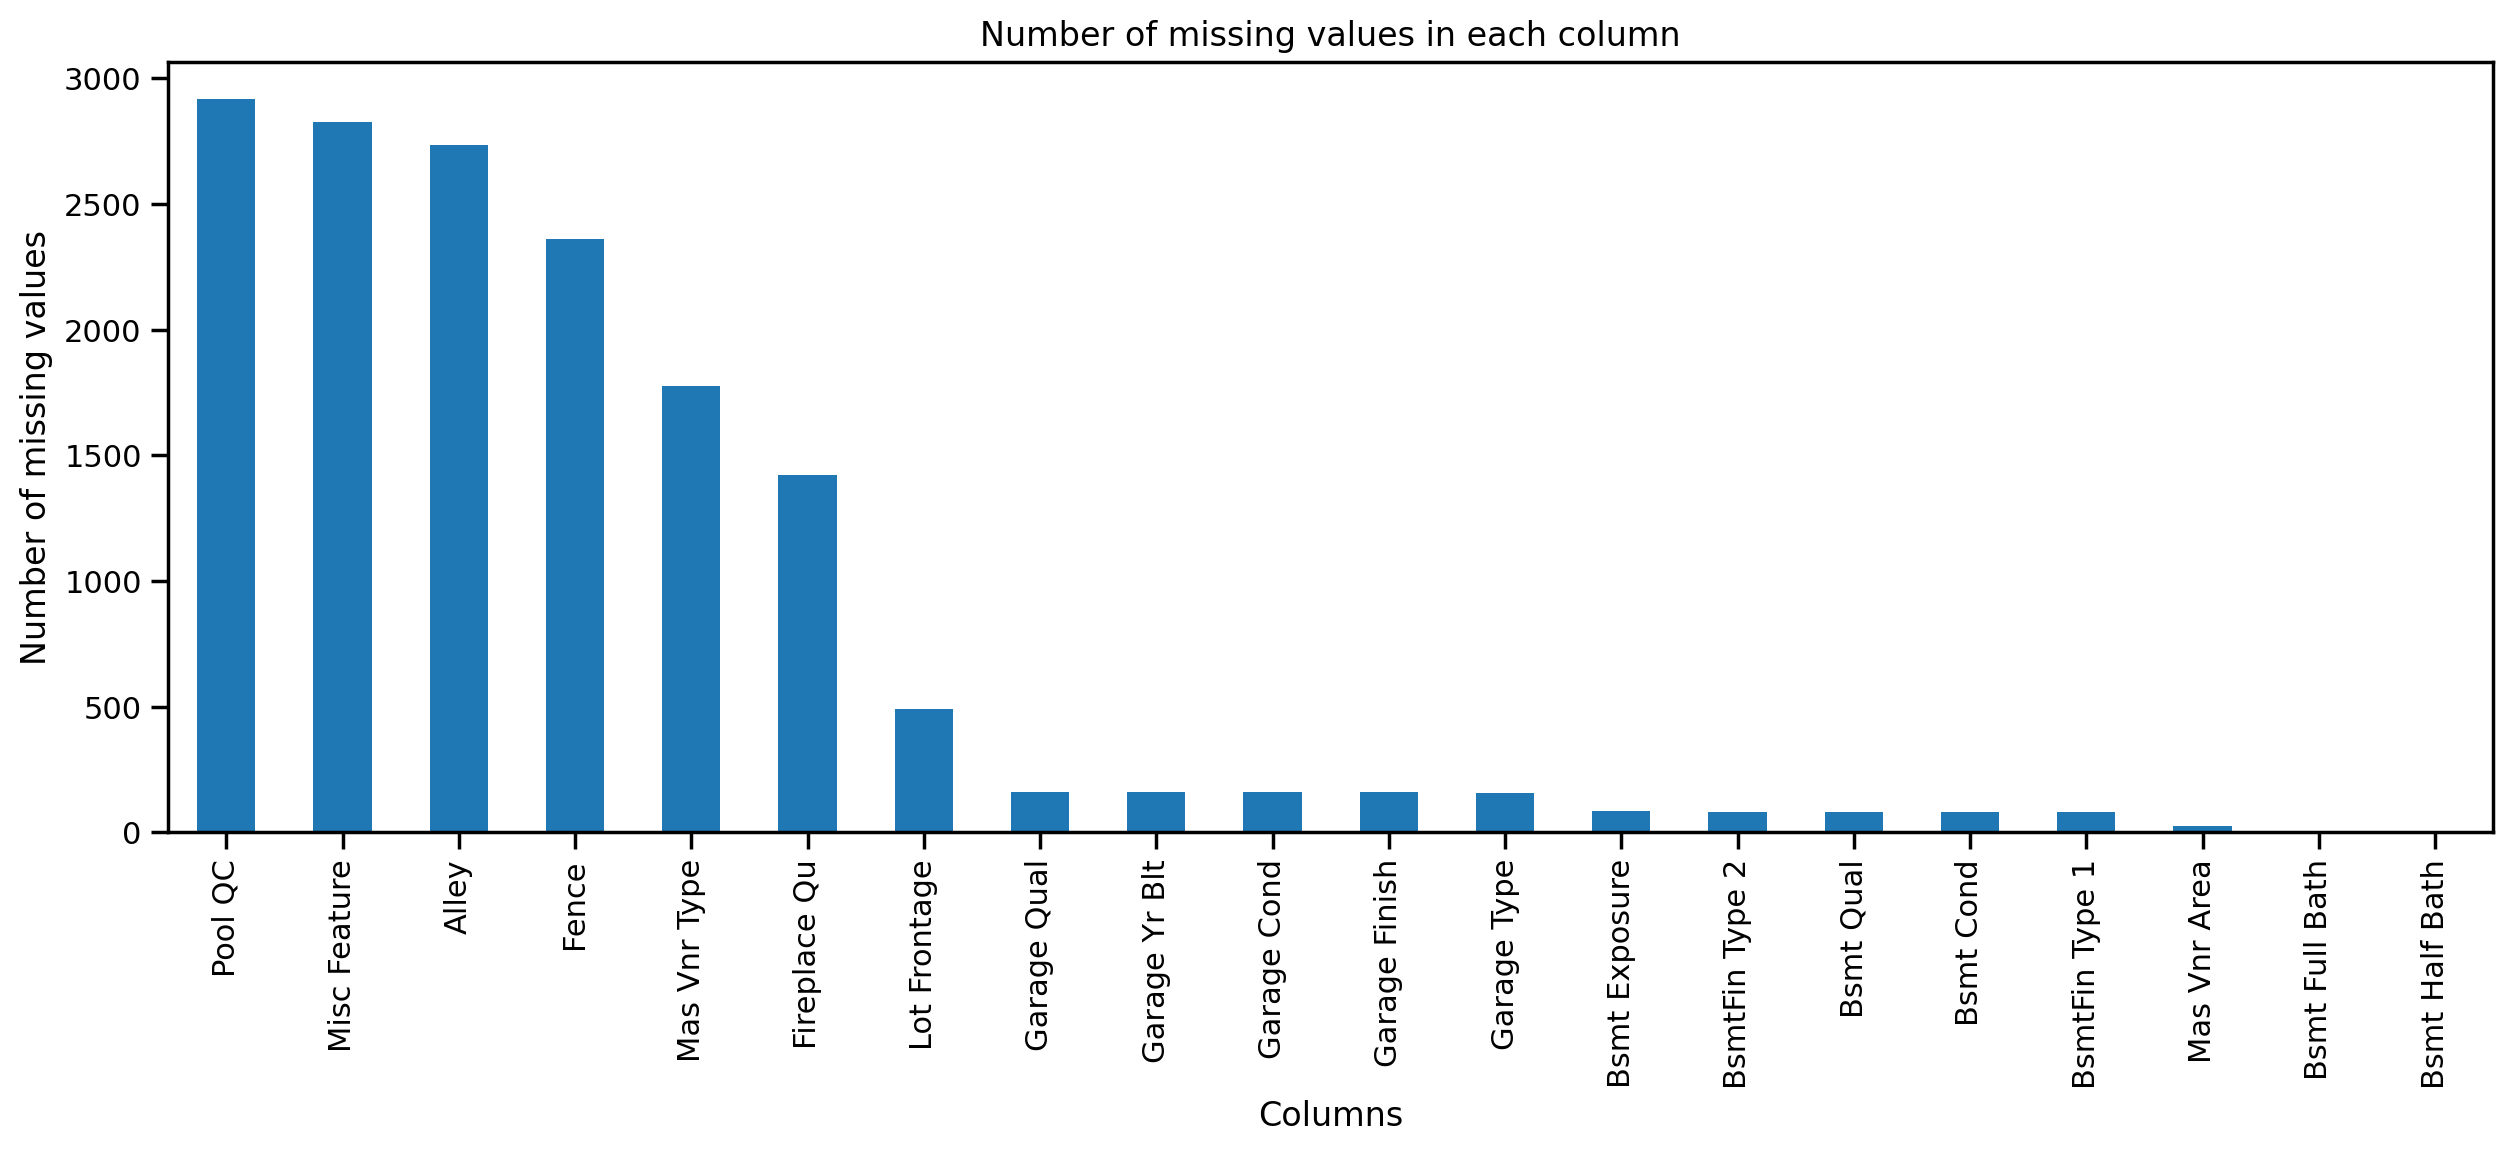

Order        PID  MS SubClass  ... Sale Type  Sale Condition SalePrice
0         1  526301100           20  ...       WD           Normal    215000
1         1  526301100           20  ...       WD           Normal    215000
2         2  526350040           20  ...       WD           Normal    105000
3         3  526351010           20  ...       WD           Normal    172000
4         4  526353030           20  ...       WD           Normal    244000
...     ...        ...          ...  ...       ...             ...       ...
2926   2926  923275080           80  ...       WD           Normal    142500
2927   2927  923276100           20  ...       WD           Normal    131000
2928   2928  923400125           85  ...       WD           Normal    132000
2929   2929  924100070           20  ...       WD           Normal    170000
2930   2930  924151050           60  ...       WD           Normal    188000

[2931 rows x 81 columns]

In [226]:
# Check number of missing values in each column
housing_data.isnull().sum().sort_values(ascending=False).head(20).plot(
    kind="bar", figsize=(15, 5)
)

# Setup the figure properties
plt.xlabel("Columns")
plt.ylabel("Number of missing values")
plt.title("Number of missing values in each column")
plt.show()

# Drop columns with specific columns with significant number of missing values
housing_data.drop("Lot Frontage", axis=1)

### Substituting with Median or Mean

In [227]:
# Fill missing values with the median value of the column
housing_data["Lot Frontage"] = housing_data["Lot Frontage"].fillna(
    housing_data["Lot Frontage"].median()
)

# Fill missing values with the mean value of the column
housing_data["Mas Vnr Area"] = housing_data["Mas Vnr Area"].fillna(
    housing_data["Mas Vnr Area"].mean()
)

### Filling Values

In [228]:
## Forward Fill
airline_data.ffill(inplace=True)

## Handling Outliers

### Analysis

#### Uni-variate Analysis

<Axes: xlabel='SalePrice'>

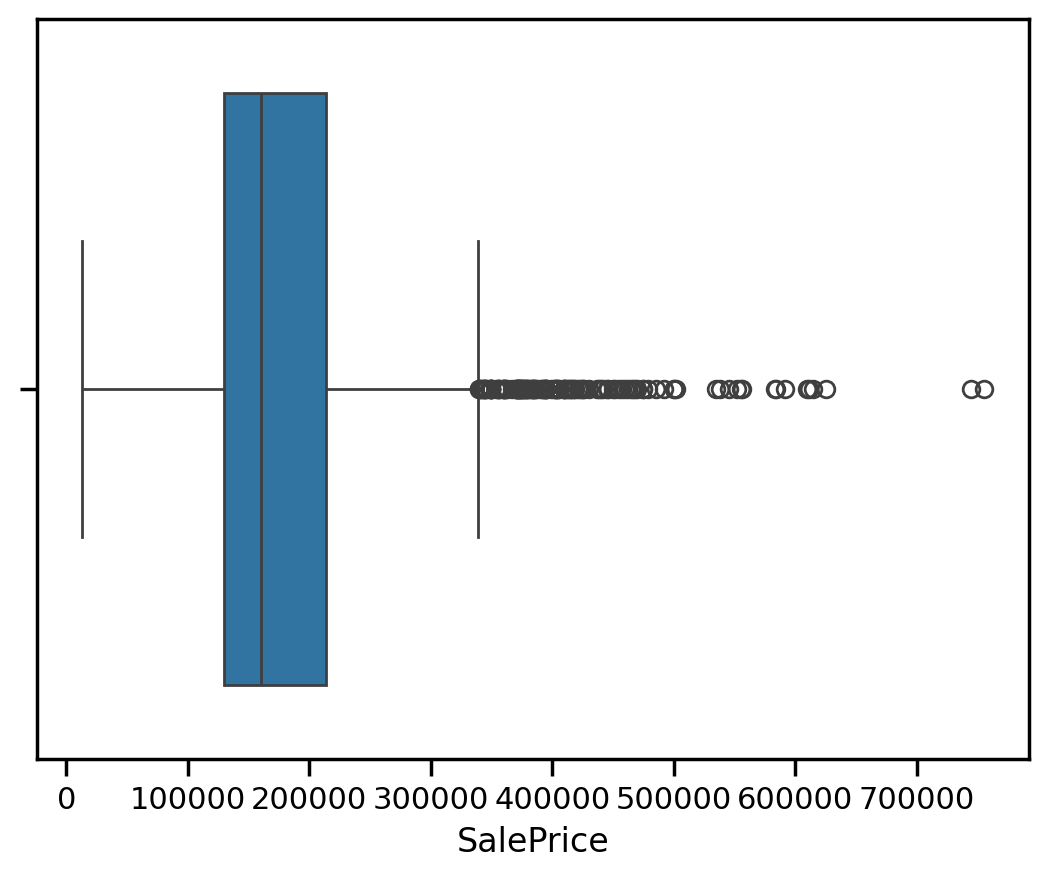

In [229]:
# Finding outliers in a dataset
sns.boxplot(x=housing_data["SalePrice"])

#### Bi-variate Analysis

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice'>

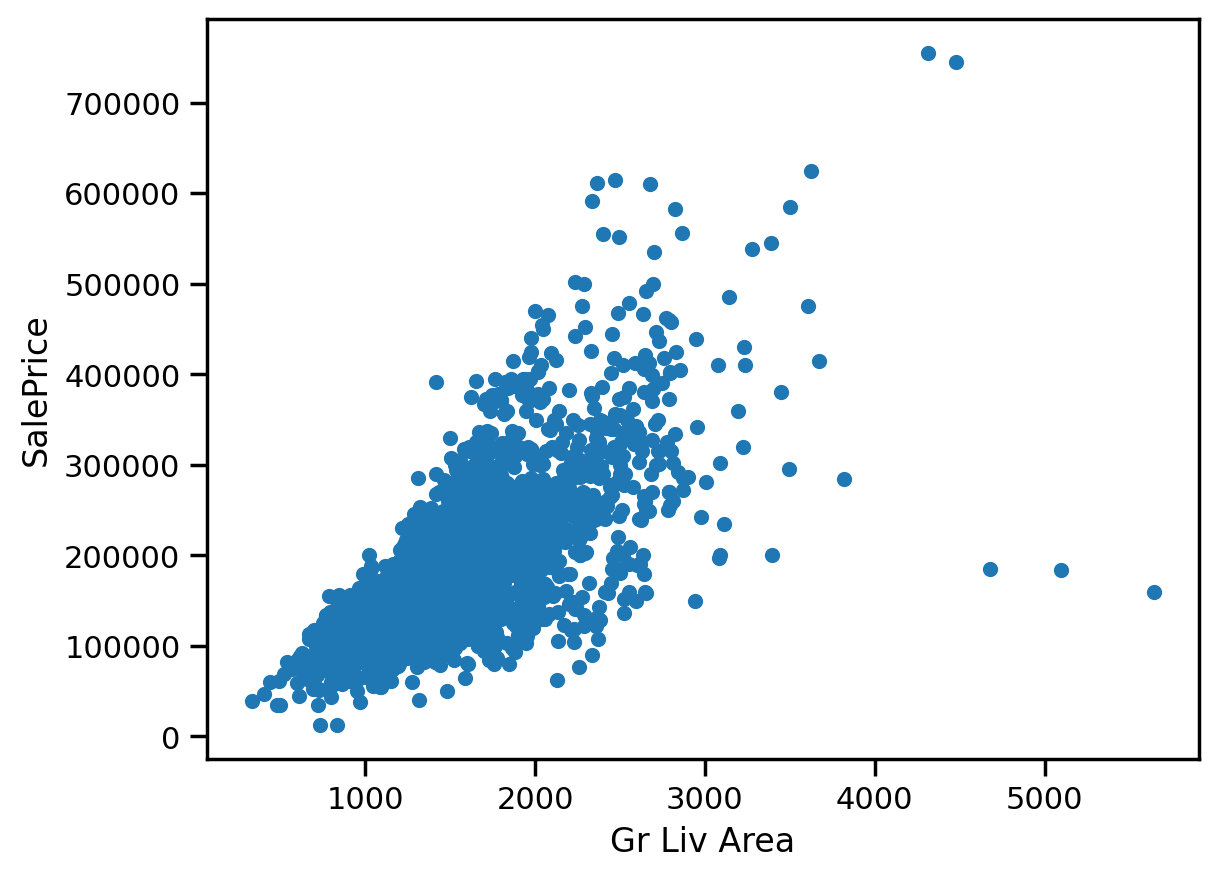

In [230]:
housing_data.plot.scatter(x="Gr Liv Area", y="SalePrice")

#### Z-Score Analysis

In [231]:
## Threshold -- Z -> 3 to -3

housing_data["LQFSF"] = stats.zscore(housing_data["Low Qual Fin SF"])

### Deleting Outliers

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice'>

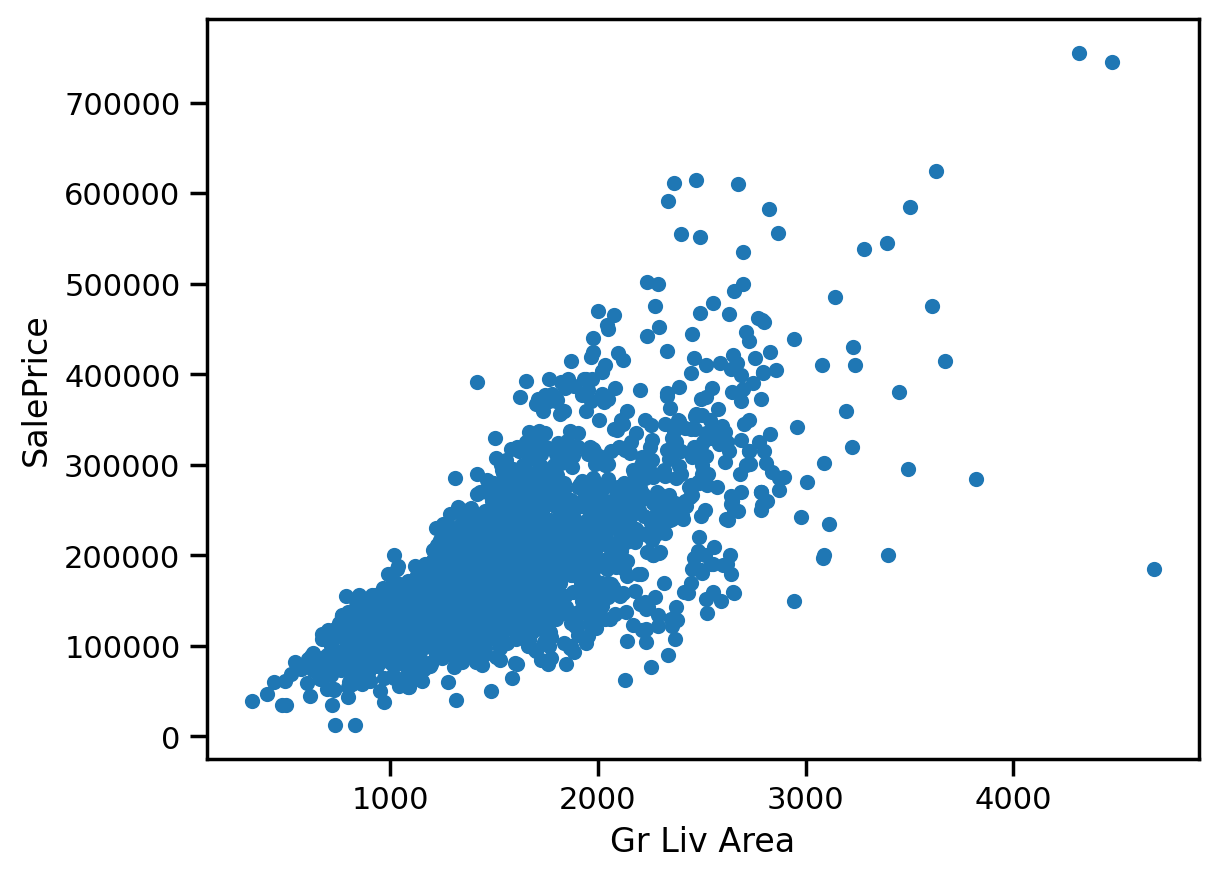

In [232]:
# Deleting specific rows
housing_data_non_null = housing_data.drop(housing_data.index[[1499, 2181]])
housing_data_non_null.plot.scatter(x="Gr Liv Area", y="SalePrice")

### Substituting Values

## Encoding Categorical Features

### Substituting Least Represented Values

In [233]:
housing_categorical_cols = housing_data.select_dtypes(include=["object"]).columns

housing_data_sub = housing_data.copy()

for col in housing_categorical_cols:
    # values                            -- Count of each unique value in the column
    # values <= 10                      -- Select the values that have a count less than or equal to 10
    # list(values[values <= 10].index)  -- Get the list of selected values
    # replace()                         -- Replace the selected values with "Others"
    values = housing_data[col].value_counts()
    housing_data_sub[col] = housing_data_sub[col].replace(
        list(values[values <= 10].index), "Others"
    )


### One Hot Encoding

In [234]:
# Encoding with Pandas get_dummies() method
housing_data_encoded = pd.get_dummies(
    housing_data_sub, columns=housing_categorical_cols, drop_first=True
)
print(f"Number of columns before encoding: {len(housing_data.columns)}")
print(f"Number of categorical columns: {len(housing_categorical_cols)}")
print(f"Number of columns after encoding: {len(housing_data_encoded.columns)}")

Number of columns before encoding: 83
Number of categorical columns: 43
Number of columns after encoding: 221


### Label Encoding

In [235]:
airline_data_encoded = airline_data.copy()

airline_data_encoded.Total_Stops = airline_data.Total_Stops.replace(
    {
        "non-stop": 0,
        "1 stop": 1,
        "2 stops": 2,
        "3 stops": 3,
        "4 stops": 4,
    }
).astype(int)

# Data Familiarization

## Introductory Analysis

In [236]:
# Display column names and data types
songs_data.info()

# Display the first 5 rows of the data
songs_data.head()

# Display the last 10 rows of the data
songs_data.tail(10)

# Display column properties
songs_data.describe()

# Display the number of unique values in each column
songs_data.nunique()

# Display the number of missing values in each column
songs_data.isnull().sum()

# Display the column names
songs_data.columns

# Displays transposed data
songs_data.T

# Display the data types of each column
songs_data.dtypes

# Display the shape of the data
songs_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Song          1650 non-null   object 
 1   Artist        1650 non-null   object 
 2   Release_Year  1650 non-null   float64
 3   PlayCount     1650 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 51.7+ KB


(1650, 4)

## Checking Basic Properties

In [237]:
# Checking column-wise properties
iris_data_props = iris_data.describe().round(2)

# Calculate value range in each column
iris_data_props.loc["range"] = (
    iris_data_props.loc["max"] - iris_data_props.loc["min"]
).round(2)
# Calculate inter-quartile range in each column
iris_data_props.loc["IQR"] = (
    iris_data_props.loc["75%"] - iris_data_props.loc["25%"]
).round(2)
# Calculate median in each column (50% is the median)
iris_data_props.rename({"50%": "median"}, inplace=True)

iris_data_props

sepal_length  sepal_width  petal_length  petal_width
count         150.00       150.00        150.00       150.00
mean            5.84         3.05          3.76         1.20
std             0.83         0.43          1.76         0.76
min             4.30         2.00          1.00         0.10
25%             5.10         2.80          1.60         0.30
median          5.80         3.00          4.35         1.30
75%             6.40         3.30          5.10         1.80
max             7.90         4.40          6.90         2.50
range           3.60         2.40          5.90         2.40
IQR             1.30         0.50          3.50         1.50

In [238]:
## Calculating aggregate statistics for different columns

# Make a aggregation dictionary
# Select all the properties to calculate for each column
agg_dict_iris = {
    "sepal_length": ["min", "max", "mean", "median", "std"],
    "sepal_width": ["min", "max"],
    "petal_length": ["min", "max", "mean", "median", "std"],
    "petal_width": ["mean", "median", "std"],
}

# Group by 'species' and calculate the aggregate statistics
iris_data.groupby("species").agg(agg_dict_iris).round(2)

sepal_length                    ... petal_length petal_width             
                    min  max  mean median  ...          std        mean median   std
species                                    ...                                      
setosa              4.3  5.8  5.01    5.0  ...         0.17        0.24    0.2  0.11
versicolor          4.9  7.0  5.94    5.9  ...         0.47        1.33    1.3  0.20
virginica           4.9  7.9  6.59    6.5  ...         0.55        2.03    2.0  0.27

[3 rows x 15 columns]

## Finding Correlations

### Correlation Matrix

In [239]:
# Calculating the correlation matrix and selecting the strongly correlated columns
# .select_dtypes(include=[np.number])   -- Selects only numerical columns as correlation can only be calculated between numerical columns
# .corr()                               -- Calculates pairwise correlation of columns
# ['SalesPrice']                        -- Selects the target column
# .abs()                                -- Takes the absolute value of the correlation so that strength of correlation is can be compared
# .sort_values(ascending=False)         -- Sorts the values in descending order
# [1:]                                  -- Excludes the the first value as it will be the target column itself and value will be 1
# .loc[lambda x : x > 0.5]              -- Filters the values greater than 0.5 i.e. Strongly correlated
# .index                                -- Selects the column names
housing_top_features_cols = (
    housing_data.select_dtypes(include=[np.number])
    .corr()["SalePrice"]
    .abs()
    .sort_values(ascending=False)[1:]
    .loc[lambda x: x > 0.5]
    .index
)
print(housing_top_features_cols)

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath',
       'Year Remod/Add', 'Garage Yr Blt', 'Mas Vnr Area'],
      dtype='object')


### Plot

<Axes: >

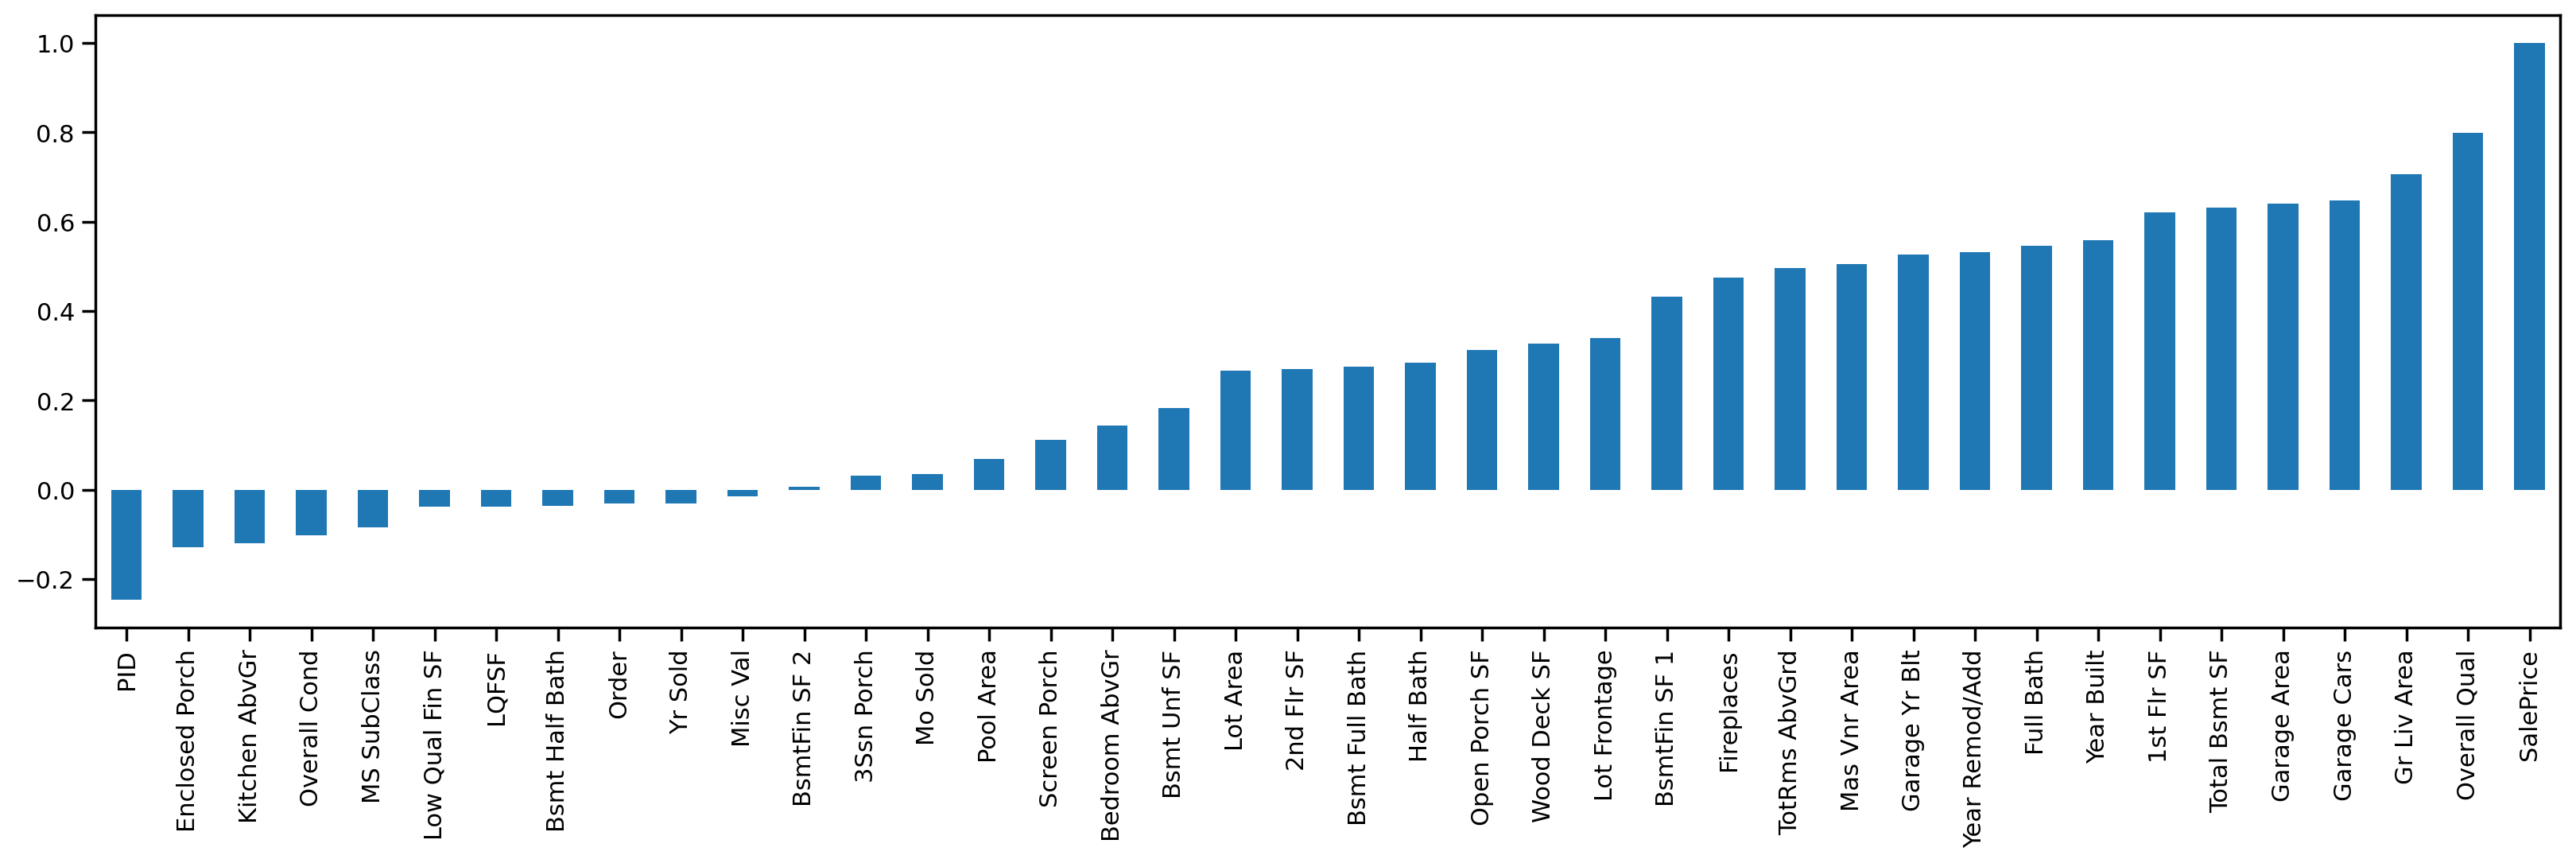

In [240]:
housing_data.select_dtypes(include=[np.number]).corr()["SalePrice"].sort_values().plot(
    kind="bar", figsize=(20, 5)
)

### Pair Plot

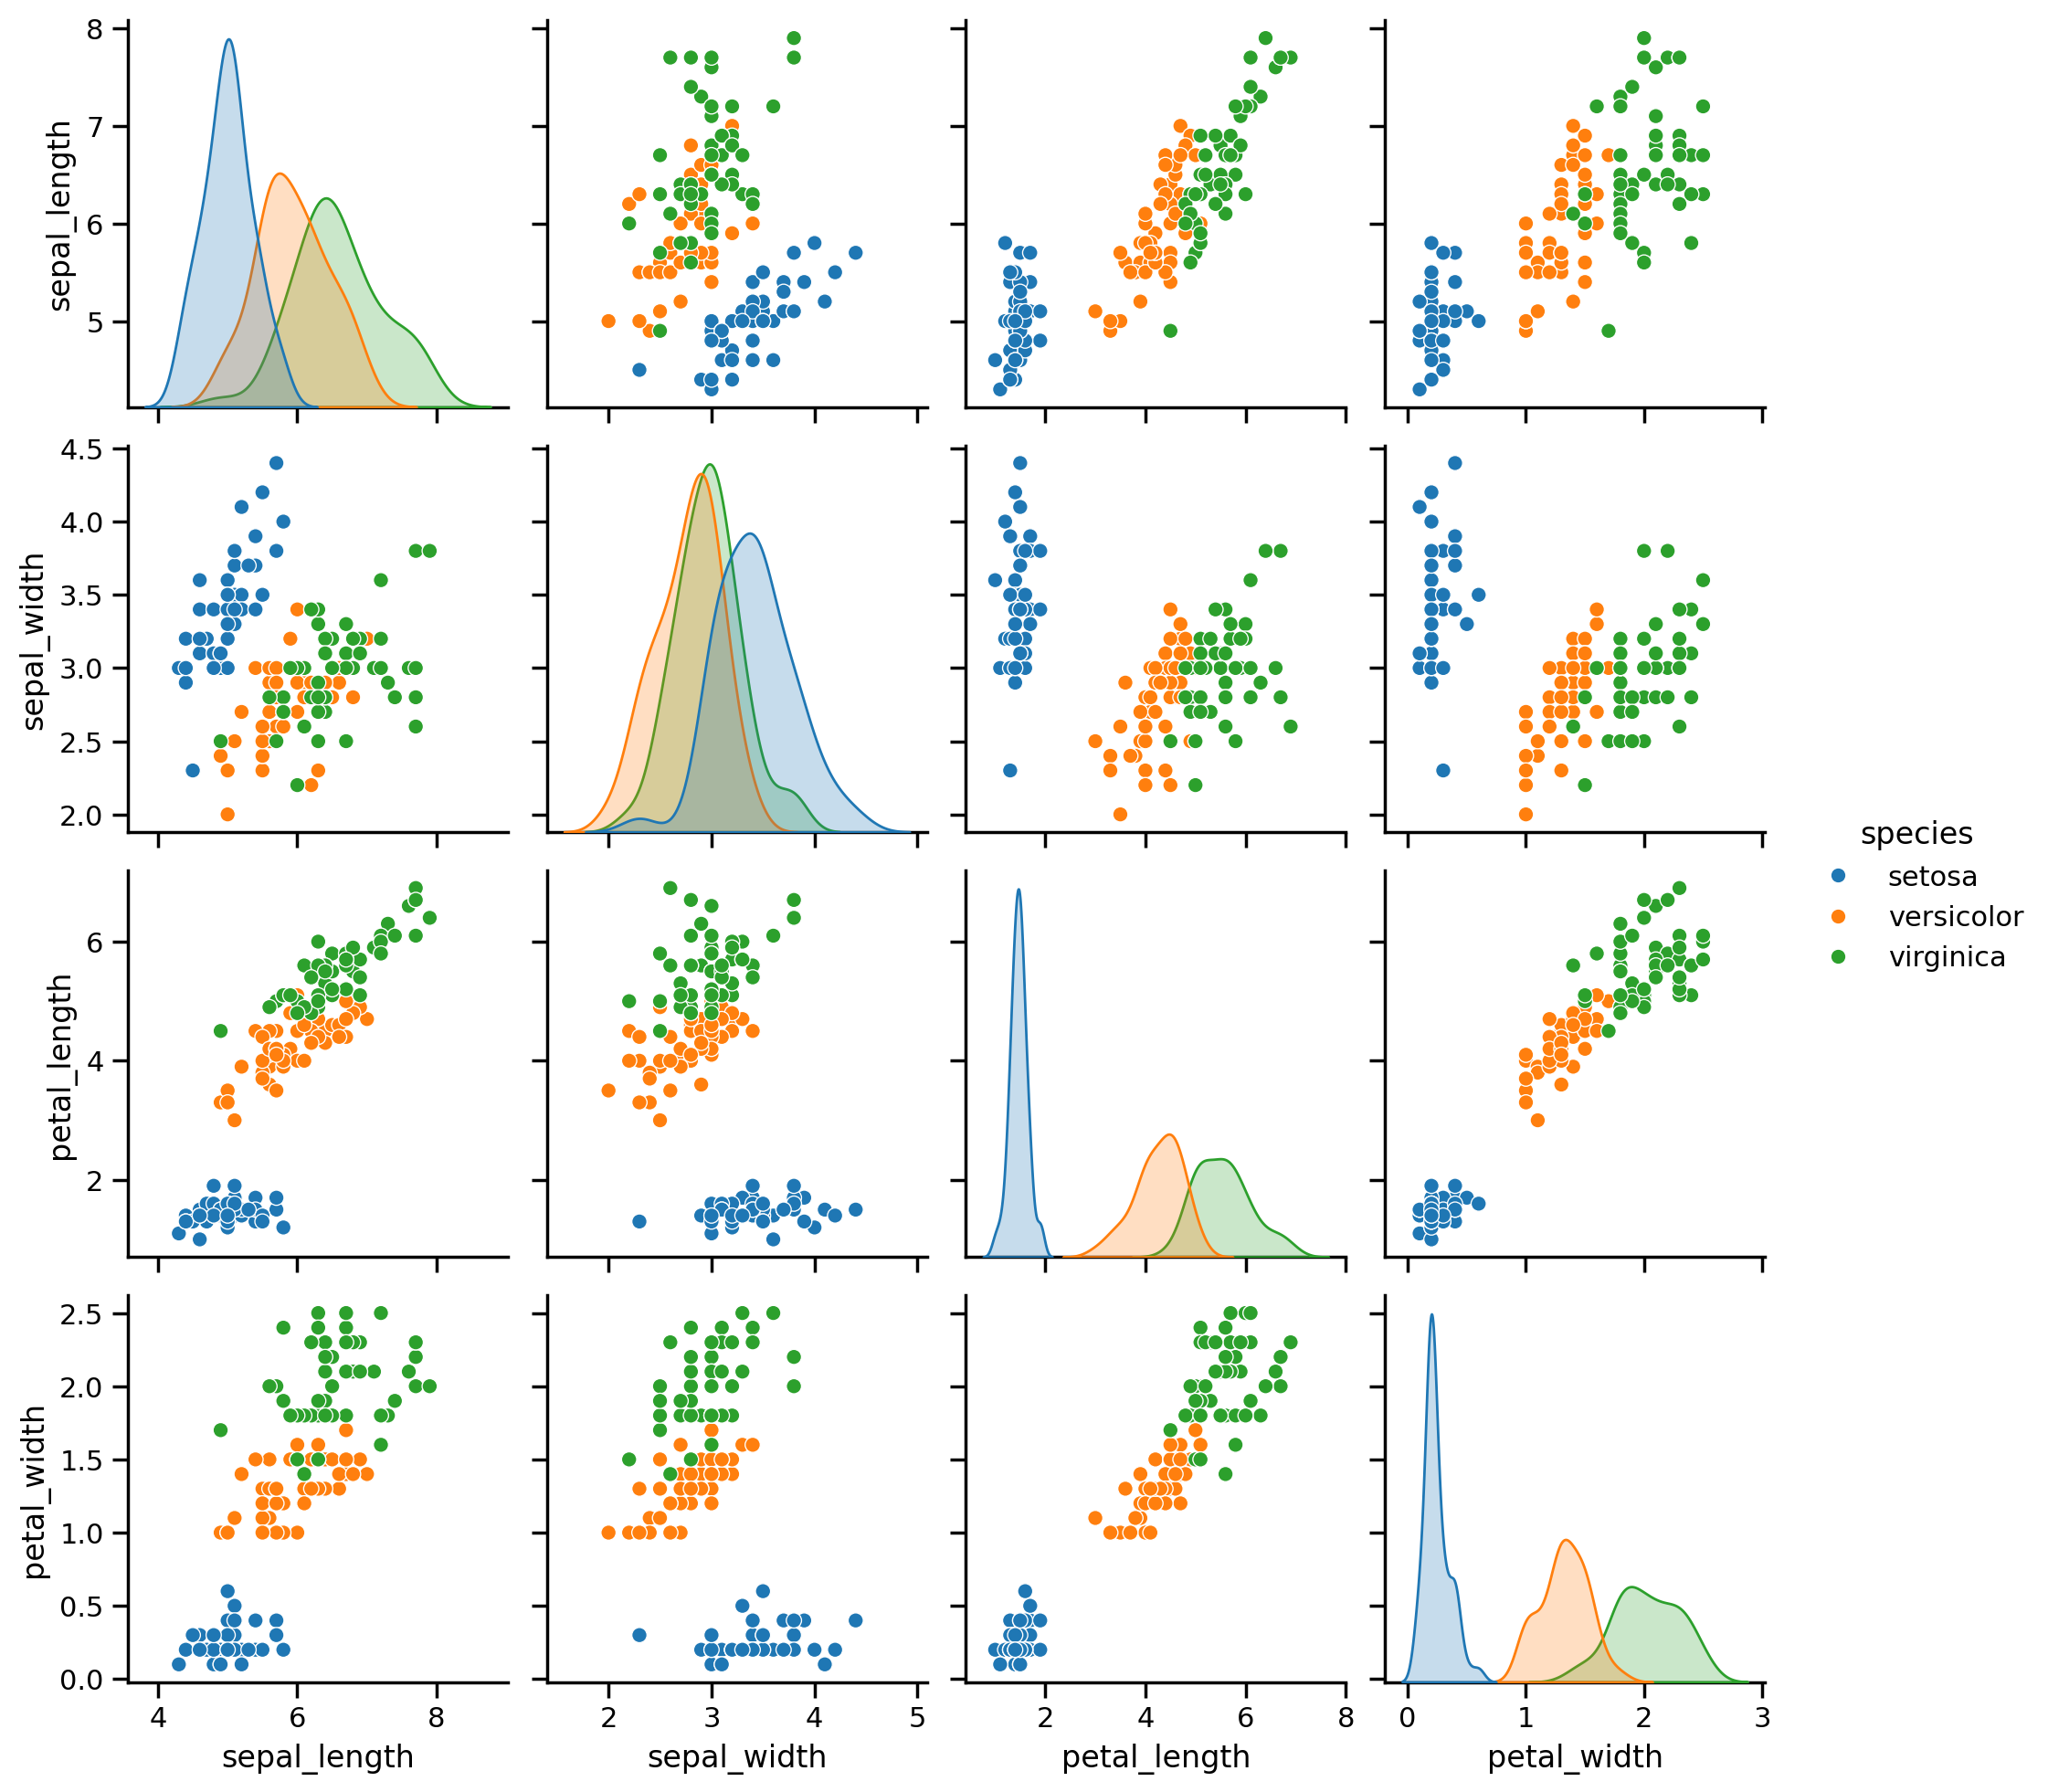

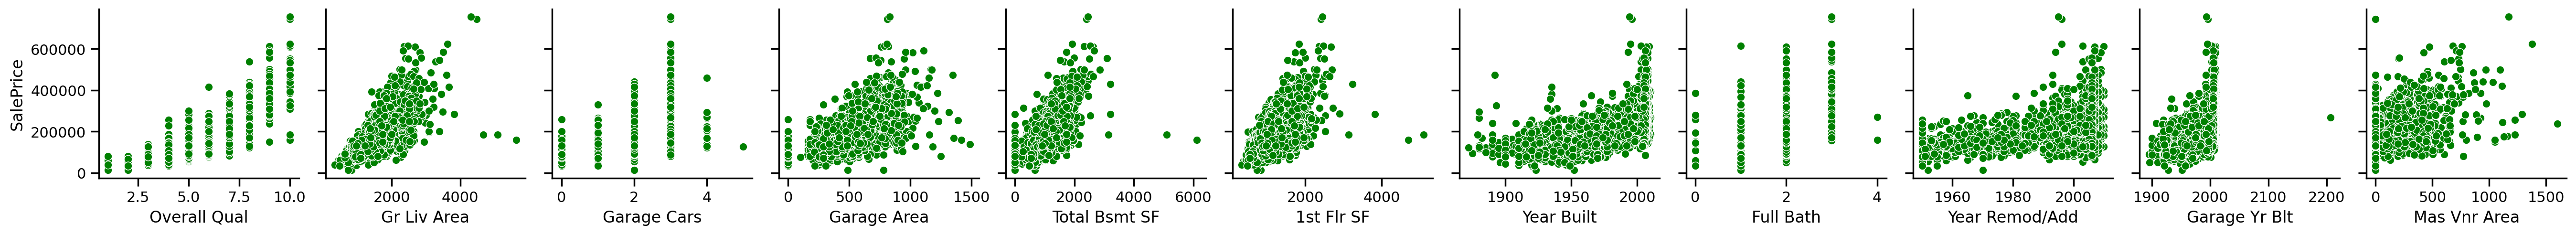

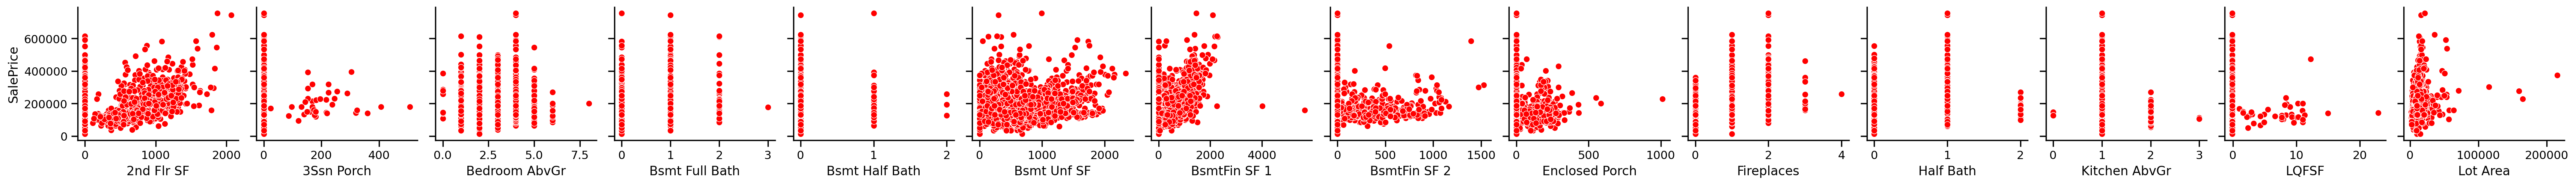

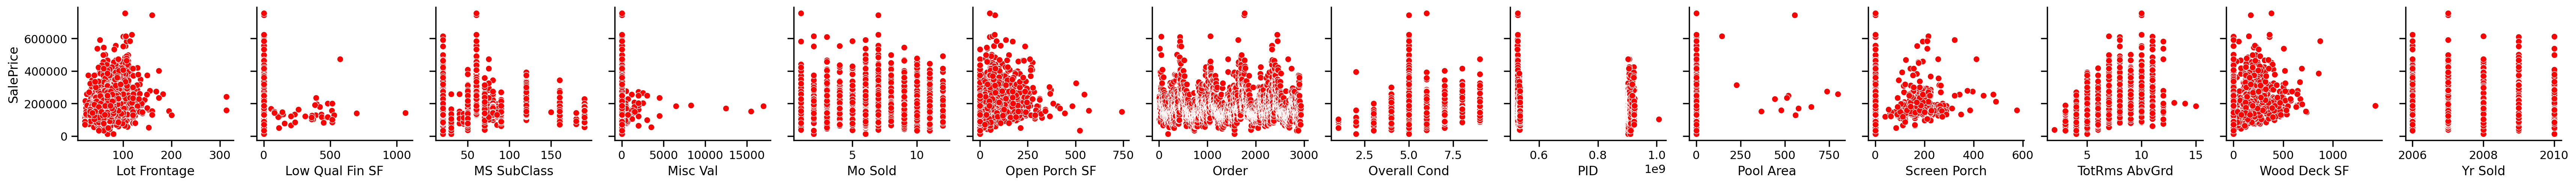

In [241]:
# Selecting numerical columns as pair plot can only be made between numerical columns
housing_data_num = housing_data.select_dtypes(include=[np.number])
housing_top_features = housing_data_num[housing_top_features_cols]

housing_weak_features = housing_data_num[
    housing_data_num.columns.difference(housing_top_features_cols).drop(["SalePrice"])
]

# Making pair plots for flowers dataset groped by species
sns.pairplot(iris_data, hue="species")

# Making pair plots of SalesPrice with strongly correlated column
for col in range(0, len(housing_top_features.columns), 12):
    sns.pairplot(
        data=housing_data_num,
        x_vars=housing_top_features.columns[col : col + 12],
        y_vars=["SalePrice"],
        plot_kws={"color": "green"},
    )

# Making pair plots of SalesPrice with each column
for col in range(0, len(housing_weak_features.columns), 14):
    sns.pairplot(
        data=housing_data_num,
        x_vars=housing_weak_features.columns[col : col + 14],
        y_vars=["SalePrice"],
        plot_kws={"color": "red"},
    )


### Heatmap

<Axes: >

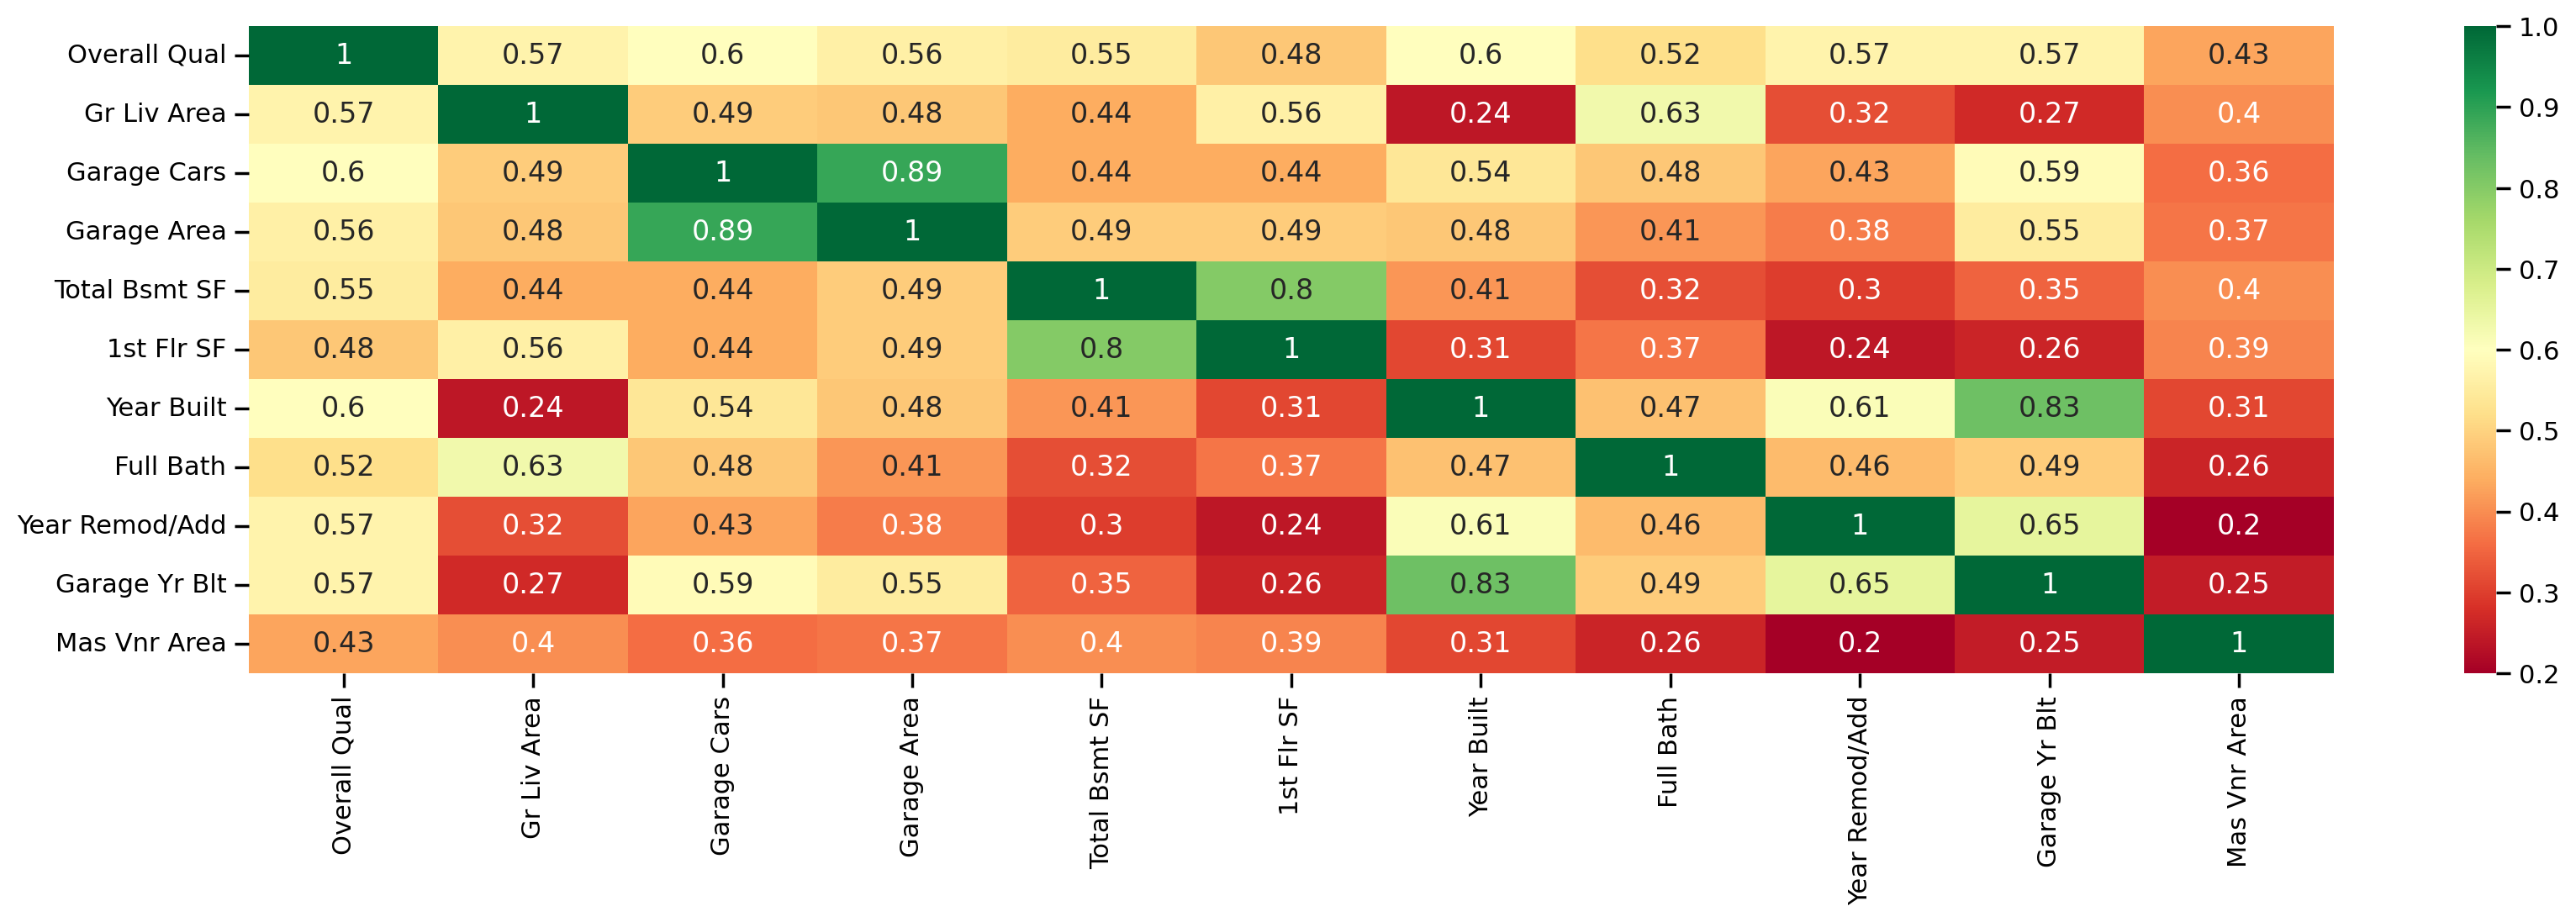

In [242]:
plt.figure(figsize=(20, 5))
sns.heatmap(
    housing_top_features.corr().round(2),
    annot=True,
    cmap="RdYlGn",
)

# Preprocessing

## Normalizing

### Checking Normal Distribution

Skewness of SalePrice: 1.74


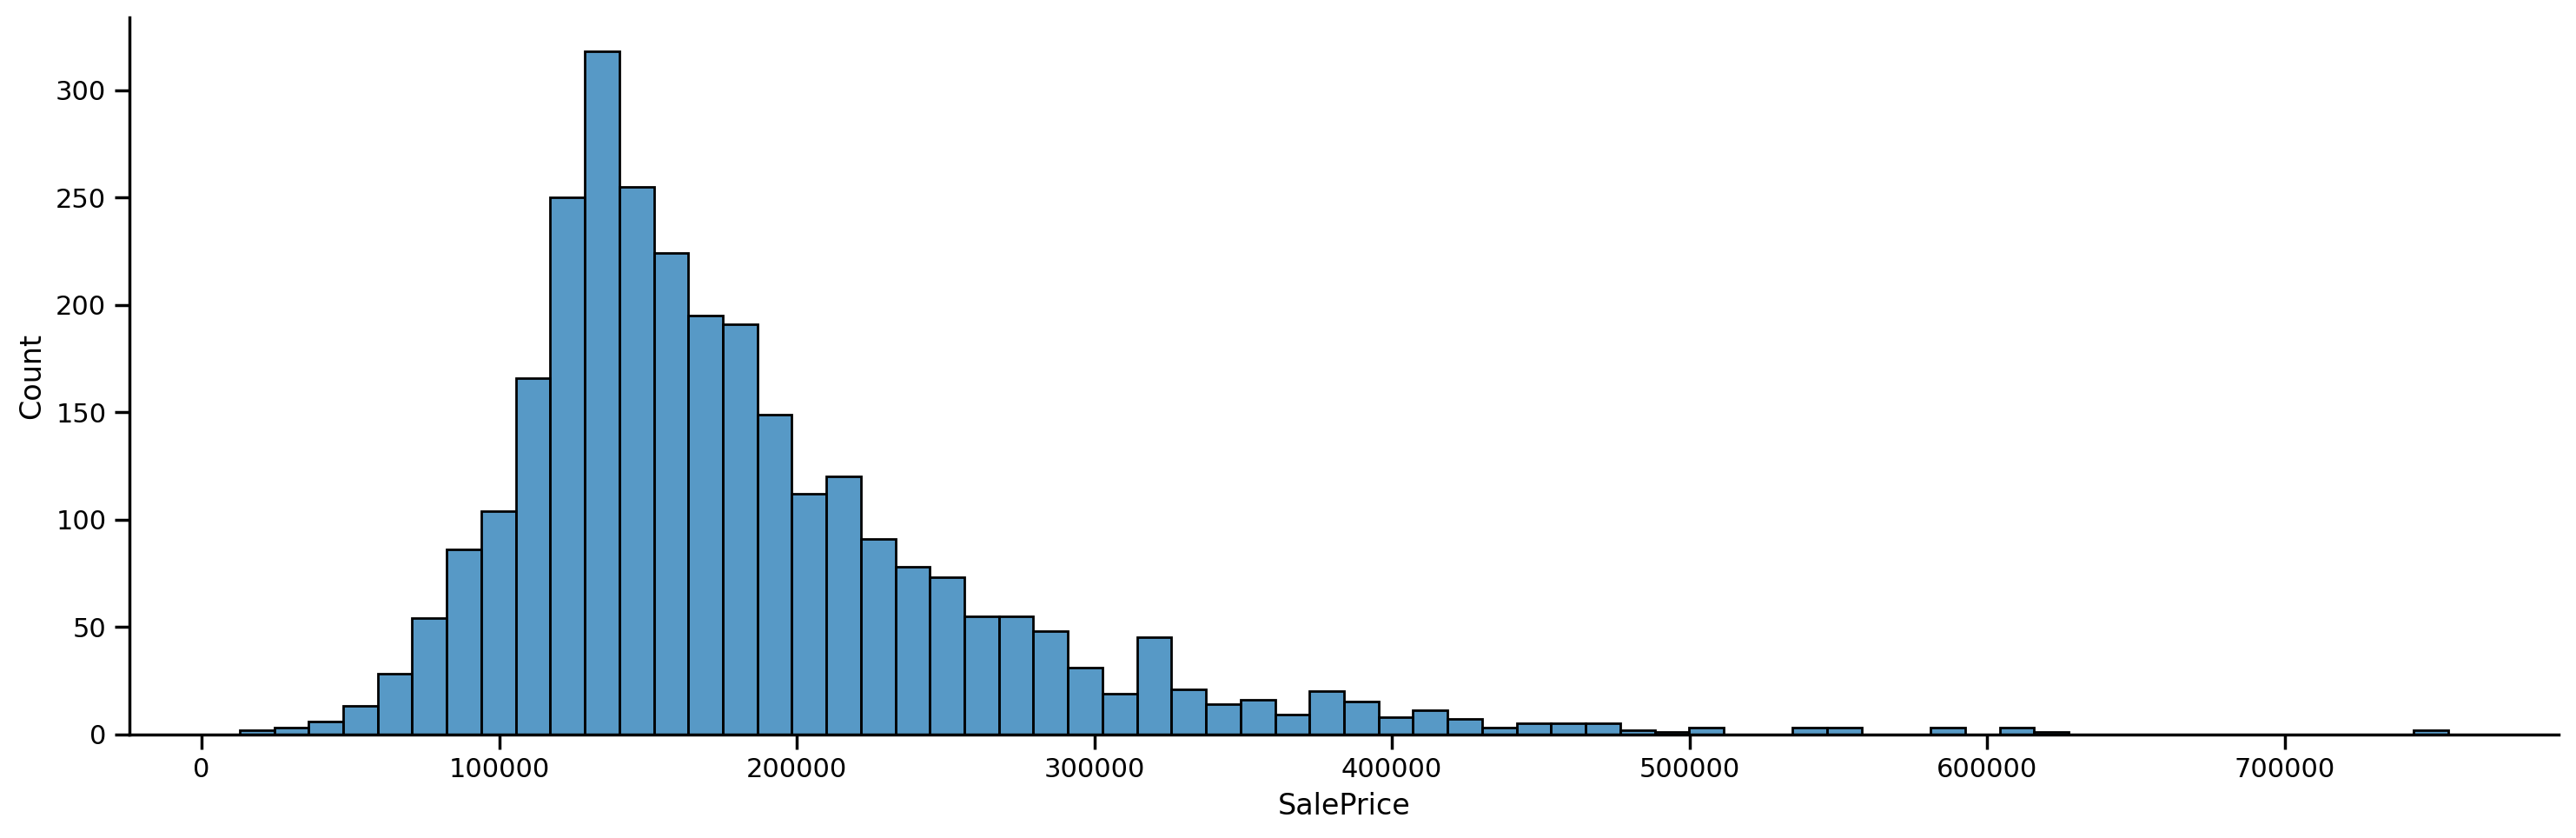

In [243]:
# Display the skewness of the SalePrice column
sales_price_skewness = housing_data["SalePrice"].skew()
print(f"Skewness of SalePrice: {sales_price_skewness.round(2)}")

# Display plot to check the distribution of SalePrice
sns.displot(housing_data["SalePrice"], aspect=3)


### Log Transformation

Skewness of SalePrice after log transformation: -0.02


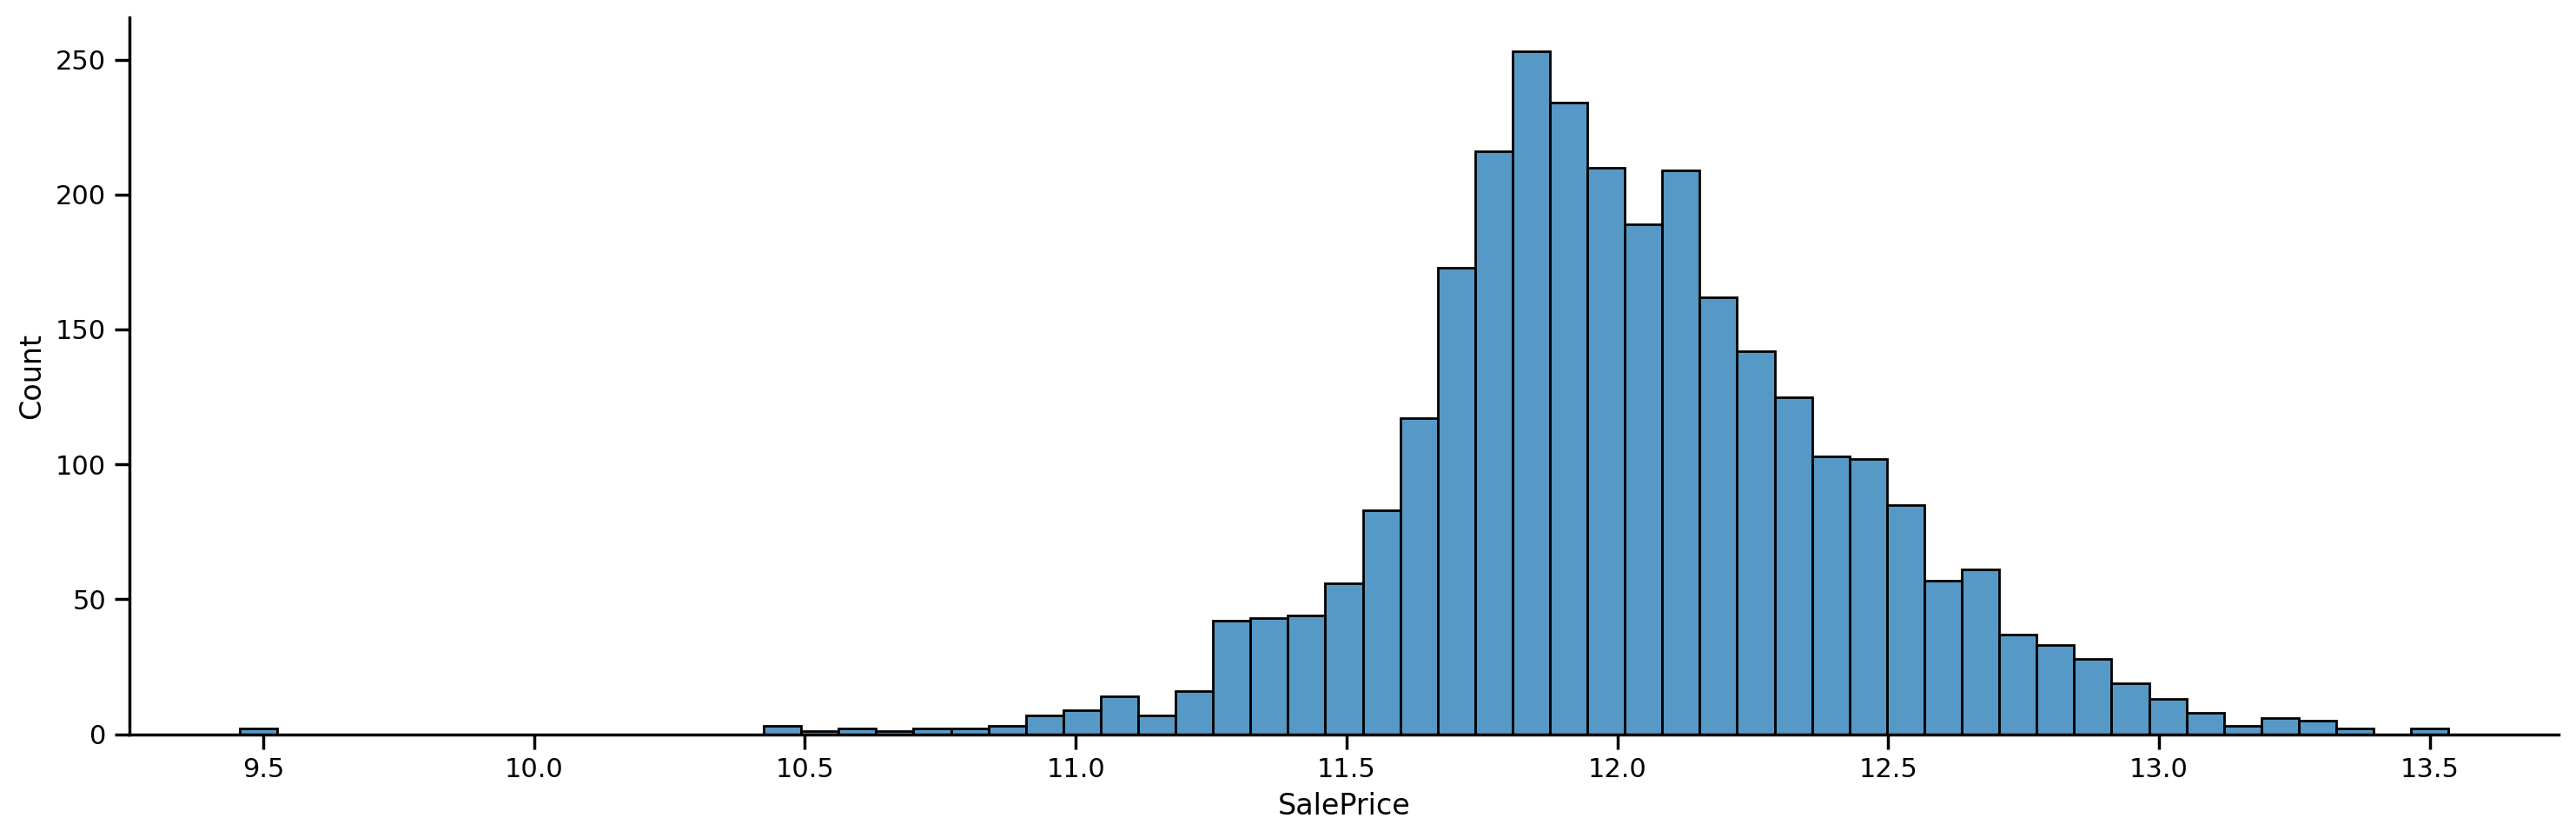

In [244]:
# Apply log transformation to the SalePrice column
# np.log1p vs np.log -- np.log1p is preferred as it do log(1+x) instead of log(x)
sales_price_log_transformed = np.log1p(housing_data["SalePrice"])

# Checking the effect of log transformation on skewness
sales_price_log_transformed_skewness = sales_price_log_transformed.skew()
print(
    f"Skewness of SalePrice after log transformation: {sales_price_log_transformed_skewness.round(2)}"
)

# Display plot to check the distribution of SalePrice after log transformation
sns.displot(sales_price_log_transformed, aspect=3)

### Square Root Transformation ???

### BoxCox Transformation ???

## Scaling Feature

### Standard Scaling

In [245]:
StandardScaler().fit_transform(housing_data_num)

array([[-1.73027969, -0.99682434, -0.87674019, ...,  1.67740664,
         0.4281423 , -0.10098753],
       [-1.73027969, -0.99682434, -0.87674019, ...,  1.67740664,
         0.4281423 , -0.10098753],
       [-1.72909781, -0.99656498, -0.87674019, ...,  1.67740664,
        -0.94923488, -0.10098753],
       ...,
       [ 1.729097  ,  1.10758639,  0.64804102, ..., -1.36026952,
        -0.61115139, -0.10098753],
       [ 1.73027889,  1.11129572, -0.87674019, ..., -1.36026952,
        -0.13533019, -0.10098753],
       [ 1.73146077,  1.11156589,  0.06158671, ..., -1.36026952,
         0.09005881, -0.10098753]], shape=(2931, 40))

### Min Max Scaling

In [246]:
MinMaxScaler().fit_transform(housing_data_num)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 2.72444089e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 2.72444089e-01, 0.00000000e+00],
       [3.41413452e-04, 1.01788895e-04, 0.00000000e+00, ...,
        1.00000000e+00, 1.24238256e-01, 0.00000000e+00],
       ...,
       [9.99317173e-01, 8.25914814e-01, 3.82352941e-01, ...,
        0.00000000e+00, 1.60616051e-01, 0.00000000e+00],
       [9.99658587e-01, 8.27370610e-01, 0.00000000e+00, ...,
        0.00000000e+00, 2.11814430e-01, 0.00000000e+00],
       [1.00000000e+00, 8.27476641e-01, 2.35294118e-01, ...,
        0.00000000e+00, 2.36066294e-01, 0.00000000e+00]], shape=(2931, 40))

## Adding Polynomial Features

In [247]:
pf = PolynomialFeatures(2)

pf.fit(housing_data[["Lot Area", "Overall Qual"]]).get_feature_names_out()

array(['1', 'Lot Area', 'Overall Qual', 'Lot Area^2',
       'Lot Area Overall Qual', 'Overall Qual^2'], dtype=object)

## Dimensionality Reduction

### Principal Component Analysis

In [248]:
pca_features = housing_data_num.drop("SalePrice", axis=1)
pca_result = housing_data_num["SalePrice"]

# Features must be non-null and numeric
pca_features.ffill(inplace=True)

# Features must be scaled before applying PCA
pca_features_scaled = StandardScaler().fit_transform(pca_features)

## PCA
pca = PCA(n_components=30)
pca.fit_transform(pca_features_scaled)

# Calculate the explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create subplot figure with 1 row and 2 columns
fig = plotly.subplots.make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Explained Variance Ratio", "Cumulative Explained Variance"],
)

# Bar plot for Explained Variance Ratio
fig.add_trace(
    plotly.graph_objects.Bar(
        x=list(range(1, len(explained_variance_ratio) + 1)),
        y=explained_variance_ratio,
        name="Explained Variance Ratio",
    ),
    row=1,
    col=1,  # Place in first column
)

# Area plot for Cumulative Explained Variance
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=list(range(1, len(cumulative_explained_variance) + 1)),
        y=cumulative_explained_variance,
        fill="tozeroy",
        mode="lines",
        name="Cumulative Explained Variance",
    ),
    row=1,
    col=2,  # Place in second column
)

# Update layout and show figure
fig.update_layout(
    title_text="PCA Variance Analysis",
    showlegend=False,
    xaxis_title="Number of Components",
    yaxis_title="Explained Variance Ratio",
    xaxis2_title="Number of Components",
    yaxis2_title="Cumulative Explained Variance",
    template="plotly_white",
).show()

# Visualization

## MatPlotLib

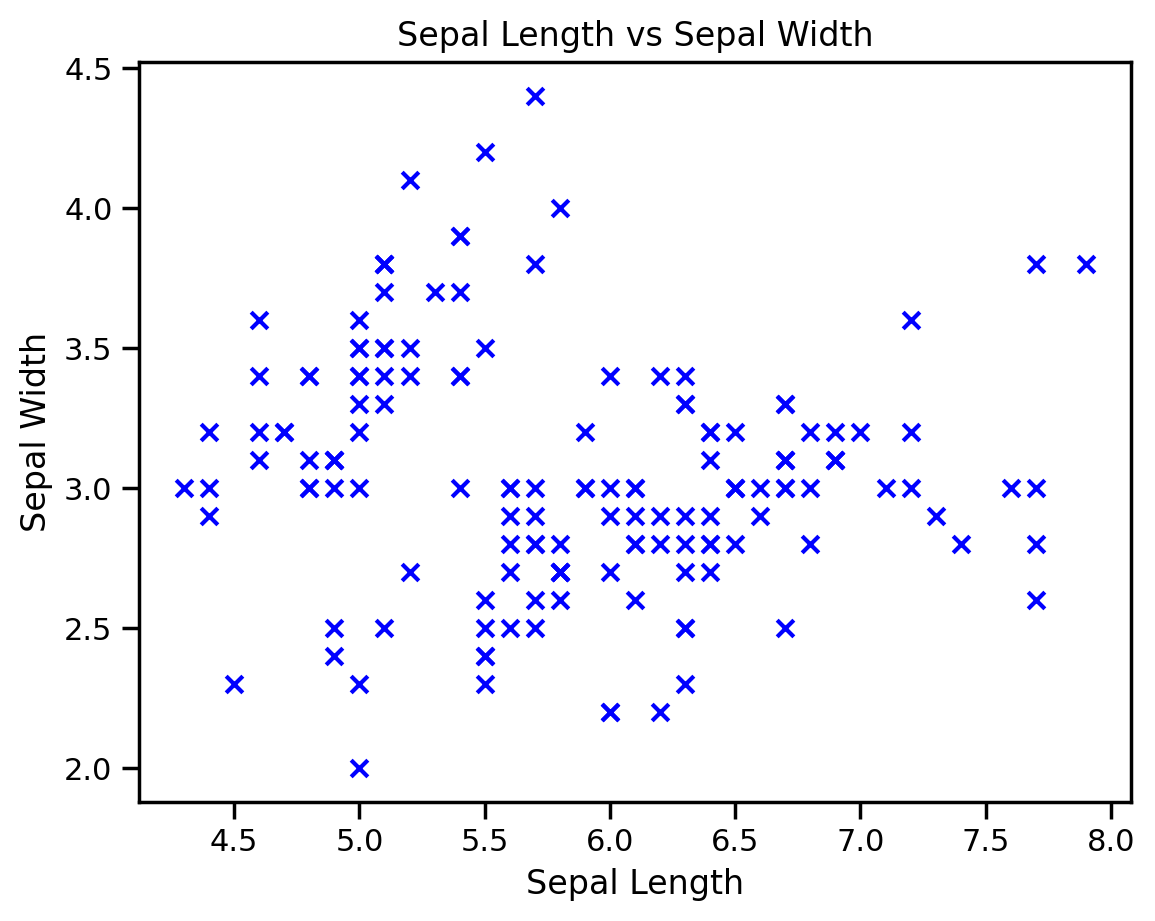

In [249]:
# Get axis object
ax = plt.axes()

# Make a Scatter Plot and set properties
ax.scatter(
    iris_data.sepal_length,
    iris_data.sepal_width,
    color="blue",
    marker="x",
)

# Setup properties of the axis
ax.set(
    xlabel="Sepal Length",
    ylabel="Sepal Width",
    title="Sepal Length vs Sepal Width",
)
plt.show()

### Multiple Plots

Text(0.5, 0.98, 'Field "SalePrice"')

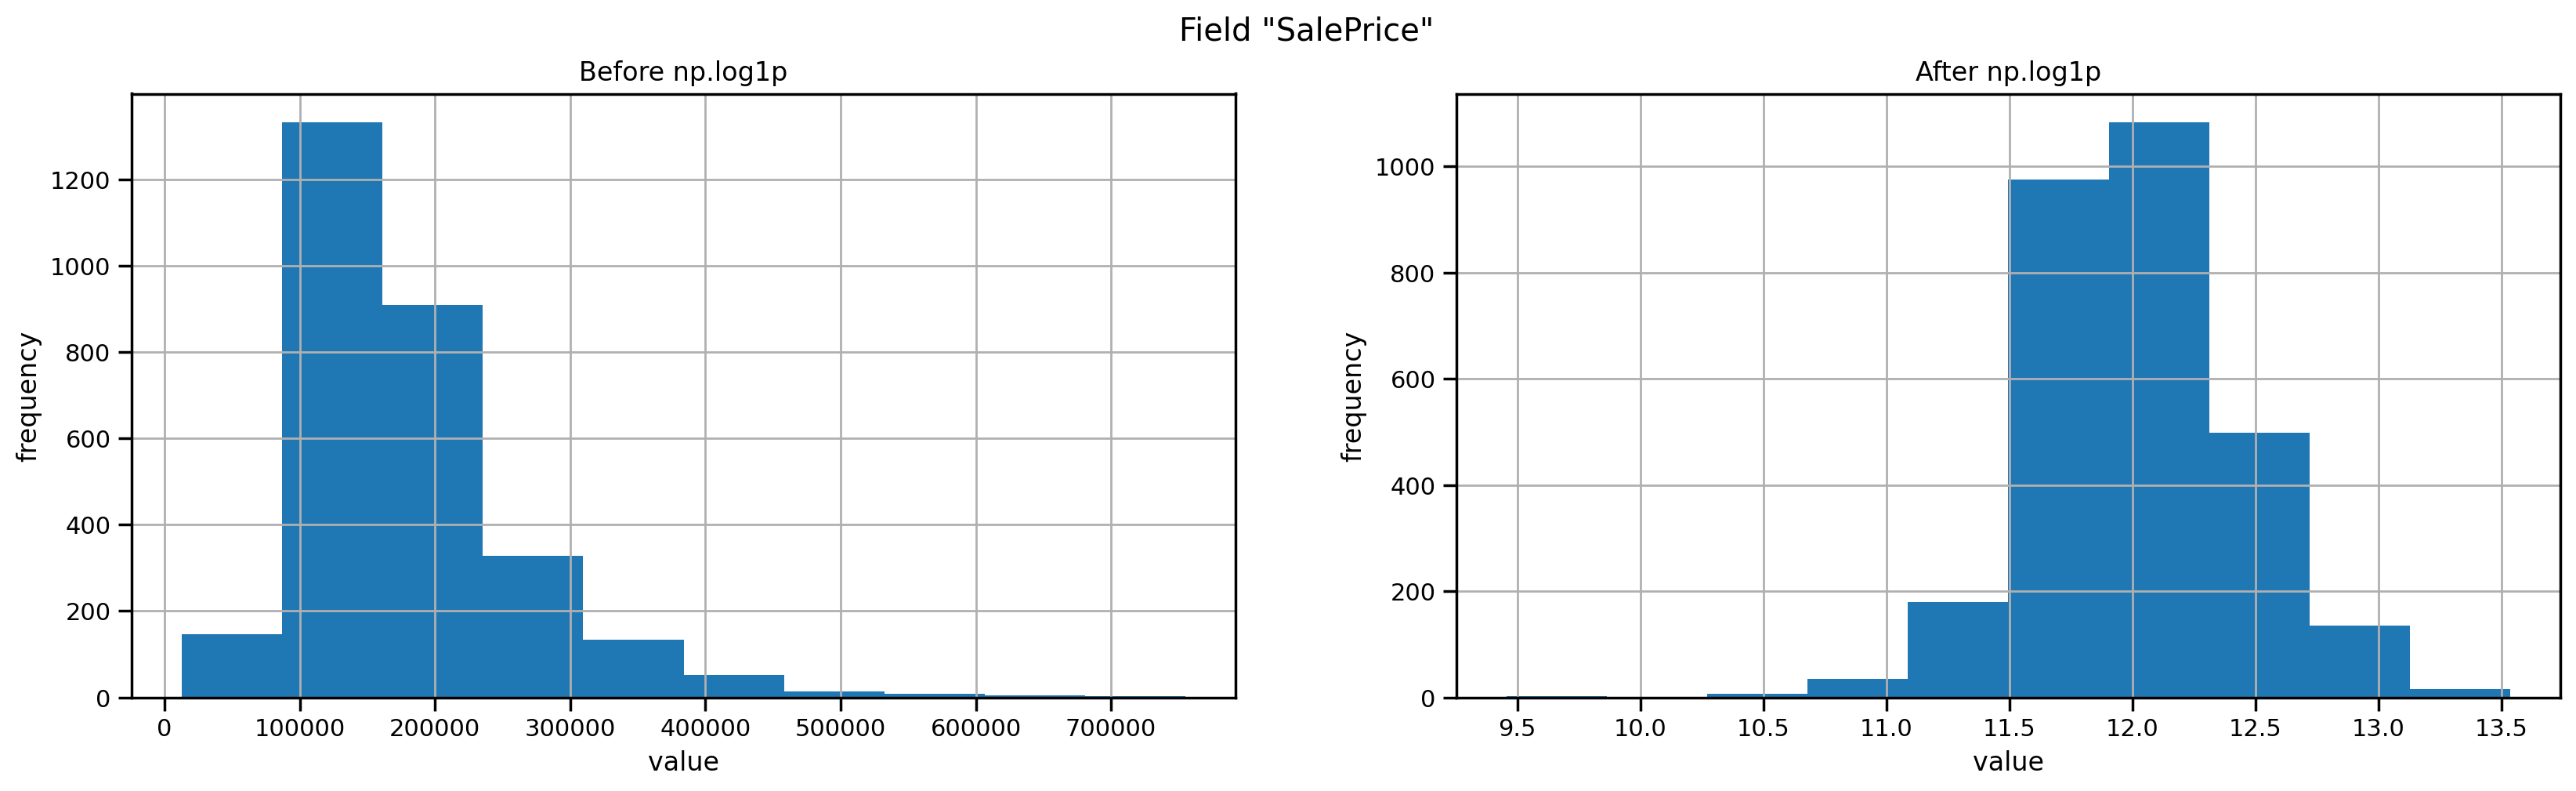

In [250]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 5),
)

housing_data.SalePrice.hist(ax=ax1)
housing_data.SalePrice.apply(lambda x: np.log1p(x)).hist(ax=ax2)

# Formatting of titles etc. for each subplot
ax1.set(title="Before np.log1p", ylabel="frequency", xlabel="value")
ax2.set(title="After np.log1p", ylabel="frequency", xlabel="value")
fig.suptitle('Field "SalePrice"')

## Seaborn

[Text(0.5, 0, 'Sepal Length'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of Sepal Length')]

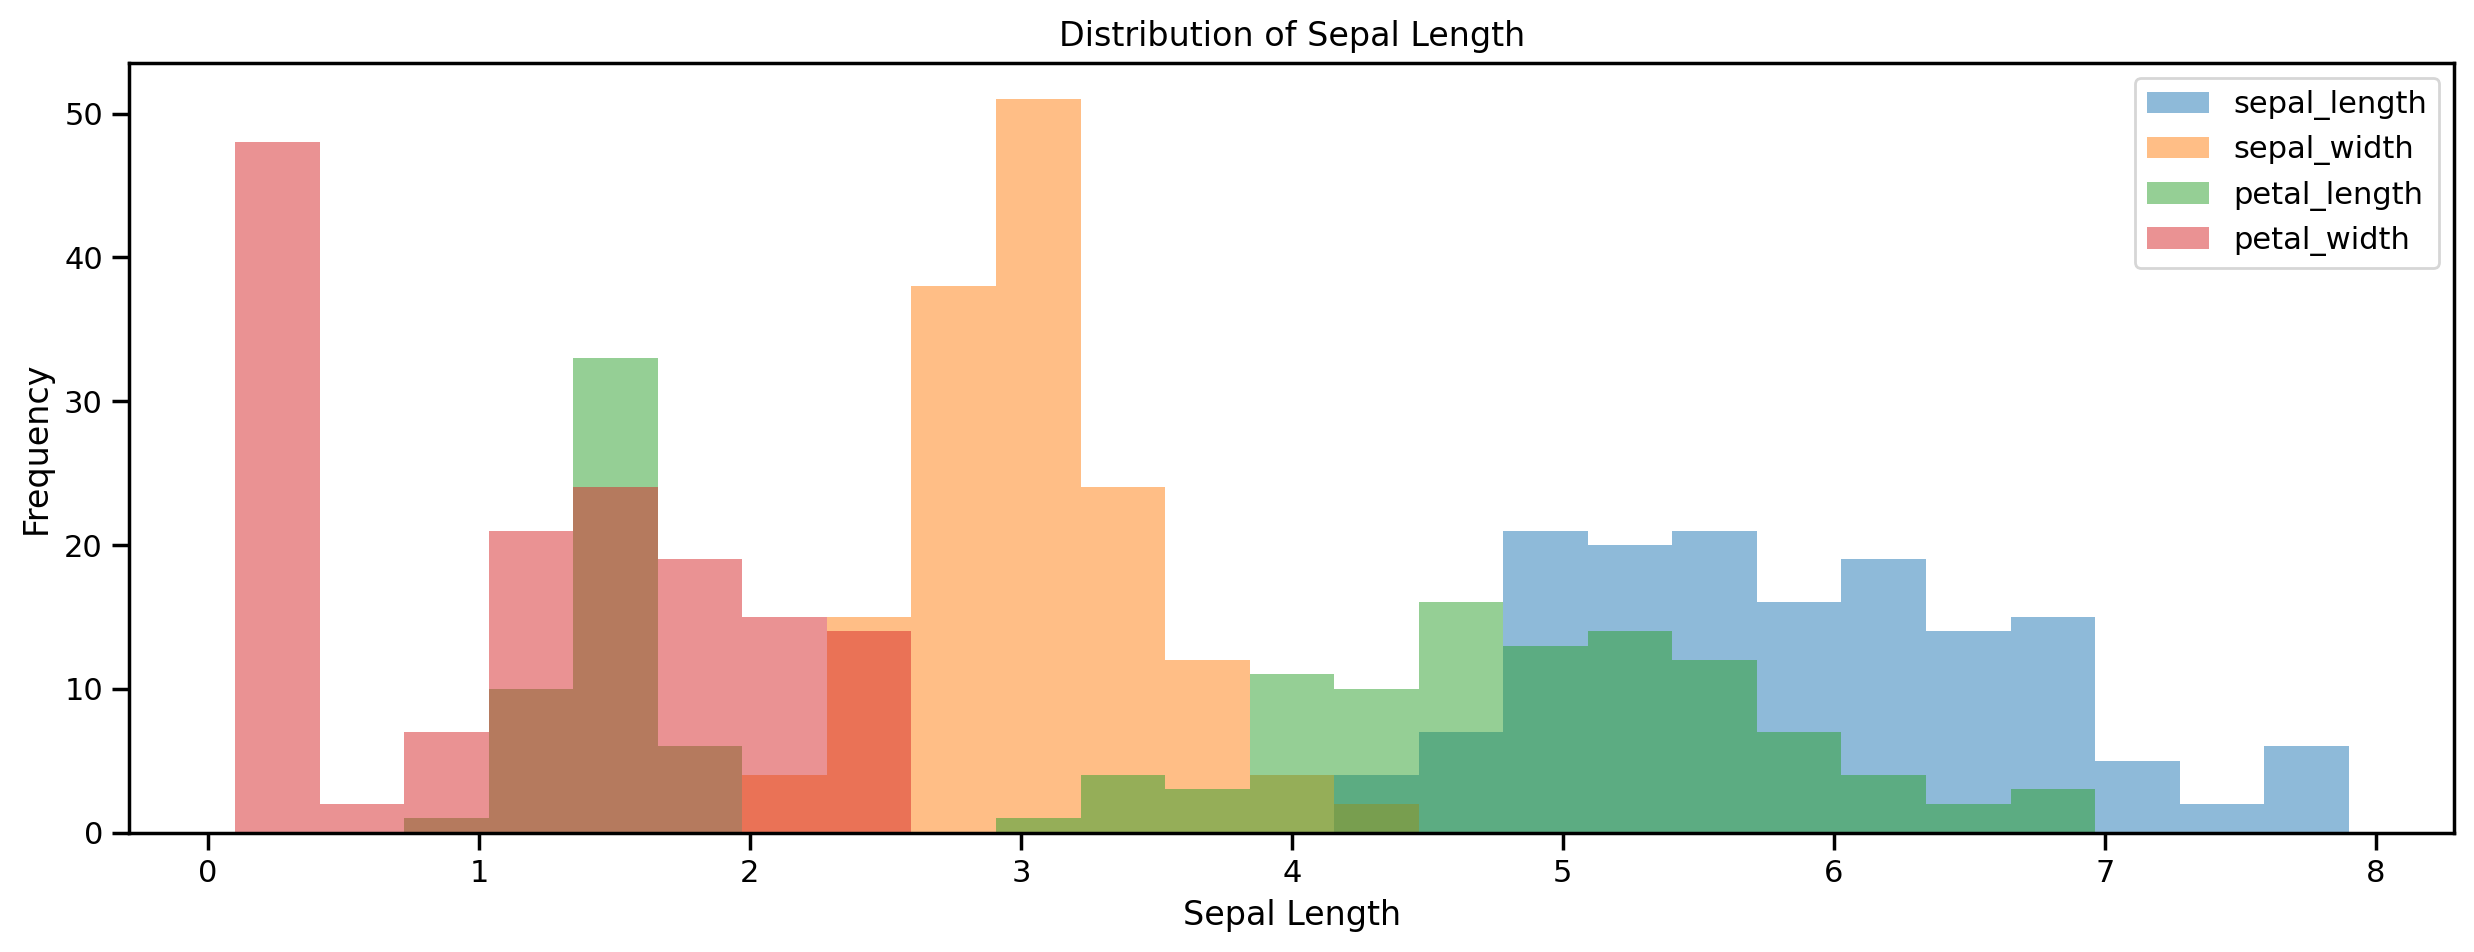

In [251]:
# Make a Histogram using the plot method (built-in method of pandas)
ax = iris_data.plot.hist(
    bins=25,
    alpha=0.5,
    figsize=(15, 5),
)

# Setup properties of the axis
ax.set(
    xlabel="Sepal Length",
    ylabel="Frequency",
    title="Distribution of Sepal Length",
)

## Plotly

In [252]:
# Getting data ready
gasoline_price_bycity = (
    gasoline_data.groupby(["Year", "City"])["VALUE"]
    .median()
    .reset_index(name="Value")
    .round(2)
)


fig = px.line(
    gasoline_price_bycity,
    x="Year",
    y="Value",
    color="City",
    color_discrete_sequence=px.colors.qualitative.Light24,
)

fig.update_traces(mode="markers+lines")
fig.update_layout(
    title="Gasoline Price Trend per City",
    xaxis_title="Year",
    yaxis_title="Annual Average Price, Cents per Litre",
)
fig.show()

fig = px.bar(
    gasoline_price_bycity,
    x="City",
    y="Value",
    animation_frame="Year",
)
fig.update_layout(
    title="Time Lapse of Average Price of Gasoline, by Province",
    xaxis_title="Year",
    yaxis_title="Average Price of Gasoline, Cents per Litre",
    yaxis=dict(range=[0, 150]),
)

fig.show()

In [253]:
gasoline_data_by_province = (
    gasoline_data[gasoline_data["Year"] == 2021]
    .groupby("Province")["VALUE"]
    .mean()
    .reset_index(name="Average Gasoline Price")
    .round(2)
)

provinces = {
    " Newfoundland and Labrador": 5,
    " Prince Edward Island": 8,
    " Nova Scotia": 2,
    " New Brunswick": 7,
    " Quebec": 1,
    " Ontario": 11,
    " Ontario part, Ontario/Quebec": 12,
    " Manitoba": 10,
    " Saskatchewan": 3,
    " Alberta": 4,
    " British Columbia": 6,
    " Yukon": 9,
    " Northwest Territories": 13,
}

# Add the ProvinceID column to the dataframe
gasoline_data_by_province["ProvinceID"] = gasoline_data_by_province["Province"].map(
    provinces
)
gasoline_data_by_province.head()

# Load the GeoJSON file to map province locations
provinces_geo = json.loads(open("data/gasoline_provinces.geojson", "r").read())

fig = px.choropleth(
    gasoline_data_by_province,
    locations="ProvinceID",
    geojson=provinces_geo,
    featureidkey="properties.cartodb_id",
    color="Average Gasoline Price",
    color_continuous_scale=px.colors.diverging.Temps,
    scope="north america",
    title="<b>Average Gasoline Price </b>",
    hover_name="Province",
    hover_data={"Average Gasoline Price": True, "ProvinceID": False},
    locationmode="geojson-id",
)
fig.update_layout(
    showlegend=True,
    height=900,
    legend_title_text="<b>Average Gasoline Price</b>",
    font={"size": 16, "color": "#808080", "family": "calibri"},
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    legend=dict(orientation="v"),
    geo=dict(bgcolor="rgba(0,0,0,0)", lakecolor="#e0fffe"),
)

# Show Canada only
fig.update_geos(
    showcountries=False,
    showcoastlines=False,
    showland=False,
    fitbounds="locations",
    subunitcolor="white",
)
fig.show()